In [12]:
import numpy as np
import pygad
import matplotlib.pyplot as plt
import os
import joblib
from mlflow.tracking import MlflowClient
import optuna
import json

In [13]:
SEED = 42

In [14]:
num_cities = 50
np.random.seed(SEED)
city_coords = np.random.rand(num_cities, 2) * 100

# Distance matrix using vectorized L2 norm
dist_matrix = np.sqrt(((city_coords[:, None, :] - city_coords[None, :, :])**2).sum(axis=2))

In [15]:
def fitness_func(ga,solution, solution_idx):
    # solution is a permutation of city indices, e.g. [3, 1, 0, 2, ...]
    tour_length = 0
    for i in range(len(solution) - 1):
        tour_length += dist_matrix[int(solution[i]), int(solution[i+1])]
    # return to start city
    tour_length += dist_matrix[int(solution[-1]), int(solution[0])]
    
    # Return negative tour length (shorter tour = higher fitness)
    return -tour_length

In [16]:

def plot_route(route, coords, title="Route"):
    fig, ax = plt.subplots(figsize=(6,6))  # make a figure and axes

    # cities
    ax.scatter(coords[:,0], coords[:,1], c="blue", s=60)
    for i, (x,y) in enumerate(coords):
        ax.text(x+1, y+1, str(i), fontsize=8)

    # route lines
    for i in range(len(route)):
        start, end = coords[route[i]], coords[route[(i+1)%len(route)]]
        ax.plot([start[0], end[0]], [start[1], end[1]], "k-")

    ax.set_title(title)
    return fig   # <-- return the Figure, not plt

In [ ]:
def objective(trial):
    params = {
        "num_generations": trial.suggest_categorical("num_generations", [1000, 1500, 2000]),
        "sol_per_pop": trial.suggest_categorical("sol_per_pop", [30, 50, 80]),
        "num_parents_mating": trial.suggest_categorical("num_parents_mating", [10, 20]),
        "parent_selection_type": trial.suggest_categorical("parent_selection_type", ["sss"]),
        "crossover_type": trial.suggest_categorical("crossover_type", ["single_point", "two_points"]),
        "mutation_type": trial.suggest_categorical("mutation_type", ["inversion"]),
        "mutation_percent_genes": trial.suggest_categorical("mutation_percent_genes", [10, 20, 30, 40]),
        "keep_parents": trial.suggest_categorical("keep_parents", [0, 5, 10]),
        "crossover_probability": trial.suggest_categorical("crossover_probability", [0.7, 0.8, 0.9, 1.0]),
    }

    ga = pygad.GA(
        num_generations=params["num_generations"],
        num_parents_mating=params["num_parents_mating"],
        fitness_func=fitness_func,
        sol_per_pop=params["sol_per_pop"],
        num_genes=num_cities,
        gene_space=list(range(num_cities)),
        parent_selection_type=params["parent_selection_type"],
        keep_parents=params["keep_parents"],
        crossover_type=params["crossover_type"],
        mutation_type=params["mutation_type"],
        mutation_percent_genes=params["mutation_percent_genes"],
        allow_duplicate_genes=False,
        gene_type=int,                     # we use permutations of ints
        random_seed=SEED,                    # for reproducibility
        crossover_probability=params["crossover_probability"],
    )
    ga.run()
    _, fitness, _ = ga.best_solution()
    best_tour_length = -fitness           # minimize tour length
    return best_tour_length               # Optuna will minimize if we set direction="minimize"

[I 2025-09-15 20:59:19,260] A new study created in memory with name: no-name-0071ae37-4d5f-41e3-b907-0e19be7cbb62
[I 2025-09-15 20:59:25,952] Trial 0 finished with value: 998.7709042463425 and parameters: {'num_generations': 1000, 'sol_per_pop': 50, 'num_parents_mating': 10, 'parent_selection_type': 'tournament', 'crossover_type': 'single_point', 'mutation_type': 'inversion', 'mutation_percent_genes': 20, 'keep_parents': 5, 'crossover_probability': 0.9}. Best is trial 0 with value: 998.7709042463425.
[I 2025-09-15 20:59:46,506] Trial 1 finished with value: 875.7846489213175 and parameters: {'num_generations': 2000, 'sol_per_pop': 80, 'num_parents_mating': 20, 'parent_selection_type': 'sss', 'crossover_type': 'single_point', 'mutation_type': 'inversion', 'mutation_percent_genes': 20, 'keep_parents': 5, 'crossover_probability': 1.0}. Best is trial 1 with value: 875.7846489213175.
[I 2025-09-15 20:59:57,072] Trial 2 finished with value: 1280.3326981797736 and parameters: {'num_generations

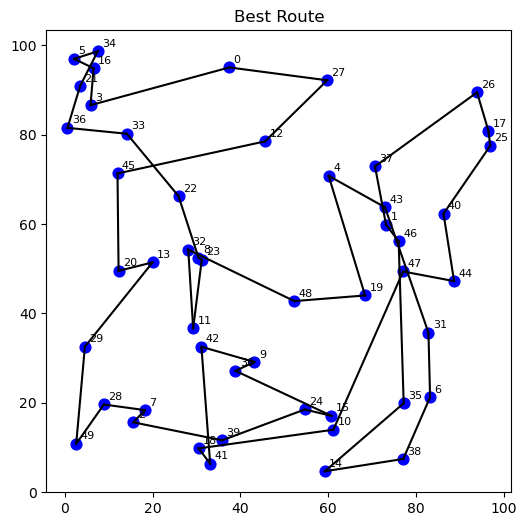

In [ ]:
# 1) search
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

# 2) re-train once with best params, then save+log artifacts
best_params = study.best_params
ga = pygad.GA(
    num_generations=best_params["num_generations"],
    num_parents_mating=best_params["num_parents_mating"],
    fitness_func=fitness_func,
    sol_per_pop=best_params["sol_per_pop"],
    num_genes=num_cities,
    gene_space=list(range(num_cities)),
    parent_selection_type=best_params["parent_selection_type"],
    keep_parents=best_params["keep_parents"],
    crossover_type=best_params["crossover_type"],
    mutation_type=best_params["mutation_type"],
    mutation_percent_genes=best_params["mutation_percent_genes"],
    allow_duplicate_genes=False,
    gene_type=int,                   # we use permutations of ints
    random_seed=SEED,                    # for reproducibility
    crossover_probability=best_params["crossover_probability"],
)

ga.run()
best_solution, best_fitness, _ = ga.best_solution()
best_tour_length = float(-best_fitness)

ga_config = {
    **best_params,
    "num_genes": num_cities,
    "allow_duplicate_genes": False,
    "gene_space": "range(num_cities)",  # documented form
}

# files to log
np.save("best_route.npy", np.array(best_solution, dtype=int))
with open("ga_config.json", "w") as f:
    json.dump(ga_config, f, indent=2)

with open("ga_state.pkl", "wb") as f:
    joblib.dump(ga, f)

fig = plot_route(best_solution, city_coords, title="Best Route")
fig.savefig("best_route.png")

metric = {
    "SEED": 42,
    "best_tour_length": best_tour_length,
    "num_cities": num_cities,
    "order_of_cities": best_solution,
}

with open("metric.json", "w") as f:
    json.dump(metric, f, indent=2)


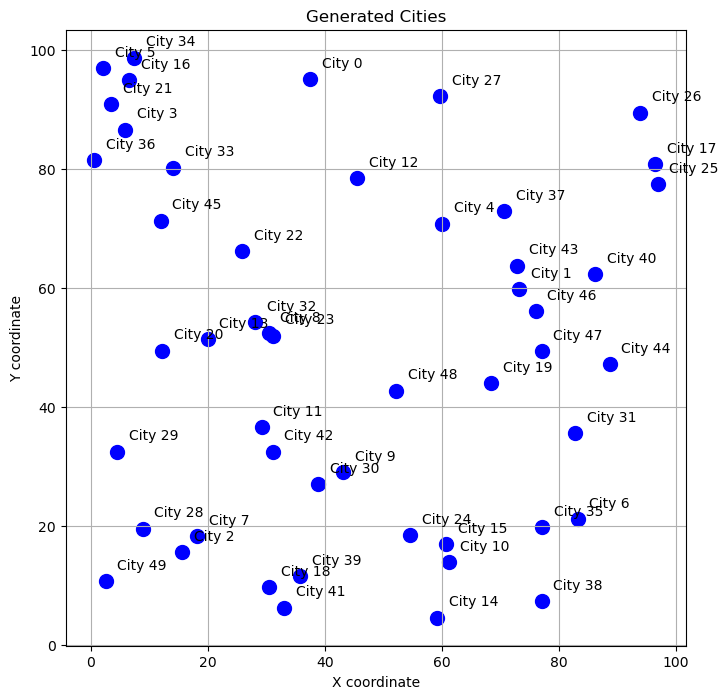

In [19]:
# Plot the cities
plt.figure(figsize=(8, 8))
plt.scatter(city_coords[:, 0], city_coords[:, 1], c="blue", s=100, marker="o")

# Label each city
for i, (x, y) in enumerate(city_coords):
    plt.text(x + 2, y + 2, f"City {i}", fontsize=10)

plt.title("Generated Cities")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.grid(True)
plt.show()